# AQI Prediction with LSTM - FIXED Version
## Key Fix:
1. Use separate scalers for features (X) and target (y) to ensure correct inverse transformation
2. This fixes the bad future predictions!
3. All plots and output styles remain the same

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc

## Load and Prepare Data

In [2]:
df = pd.read_csv('data.csv')

df['temp_date'] = pd.to_datetime(df['Date'].astype(str) + '-2020', format='%d-%b-%Y')
years = []
current_year = 2017
prev_month = 3  

for idx, row in df.iterrows():
    current_month = row['temp_date'].month
    if current_month < prev_month:
        current_year += 1
    years.append(current_year)
    prev_month = current_month

df['Year'] = years

date_strings = df['Year'].astype(str) + df['temp_date'].dt.strftime('-%m-%d')

df['Date'] = pd.to_datetime(date_strings)
df.set_index('Date', inplace=True)
df.drop(['temp_date', 'Year'], axis=1, inplace=True)

In [3]:
# Keep only stable sensors
stable_sensors = ['2', '5', '6', '9', '12']
df_sensors = df[stable_sensors]

# Fill missing values
df_sensors = df_sensors.interpolate(method='linear').fillna(method='bfill')

# IMPORTANT: Make it daily frequency
df_sensors = df_sensors.asfreq('D')
df_sensors = df_sensors.interpolate(method='linear')

/var/folders/hd/hqx41svd20lcfdp6nt85c0j80000gn/T/ipykernel_4234/3363375190.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sensors = df_sensors.interpolate(method='linear').fillna(method='bfill')


## CHANGE 1: Choose your approach

### Option A: Use AVERAGE of all sensors (RECOMMENDED)
This gives you a more robust overall AQI measure

In [4]:
'''# Option A: Average AQI across all sensors
data = pd.DataFrame()
data['AQI'] = df_sensors.mean(axis=1)  # Average across sensors
'''

"# Option A: Average AQI across all sensors\ndata = pd.DataFrame()\ndata['AQI'] = df_sensors.mean(axis=1)  # Average across sensors\n"

### Option B: Use single sensor (Alternative)

In [5]:
# Option B: Single sensor
data = pd.DataFrame()
data['AQI'] = df_sensors['2']  # Using sensor 2
print(f"Using sensor: 2")
print(f"Data shape: {data.shape}")
data.head()

Using sensor: 2
Data shape: (1296, 1)


,AQI
Date,
2017-03-22,92.0
2017-03-23,85.0
2017-03-24,44.0
2017-03-25,59.0
2017-03-26,48.0


## CHANGE 2: Create Time-Based Features

In [6]:
# Setting lookback period
lookback = 7

# Create lagged features
shifted_df = data.copy()
for i in range(1, lookback + 1):
    shifted_df[f'AQI(t-{i})'] = data['AQI'].shift(i)

# Drop NaN rows
shifted_df = shifted_df.dropna().reset_index(drop=False)
shifted_df.set_index('Date', inplace=True)

print(f"Original data shape: {data.shape}")
print(f"After creating lagged features: {shifted_df.shape}")
shifted_df.head(10)

Original data shape: (1296, 1)
After creating lagged features: (1289, 8)


,AQI,AQI(t-1),AQI(t-2),AQI(t-3),AQI(t-4),AQI(t-5),AQI(t-6),AQI(t-7)
Date,,,,,,,,
2017-03-29,31.00,24.00,26.00,48.00,59.0,44.0,85.0,92.0
2017-03-30,30.00,31.00,24.00,26.00,48.0,59.0,44.0,85.0
2017-03-31,31.00,30.00,31.00,24.00,26.0,48.0,59.0,44.0
2017-04-01,24.00,31.00,30.00,31.00,24.0,26.0,48.0,59.0
2017-04-02,38.00,24.00,31.00,30.00,31.0,24.0,26.0,48.0
2017-04-03,32.00,38.00,24.00,31.00,30.0,31.0,24.0,26.0
2017-04-04,33.25,32.00,38.00,24.00,31.0,30.0,31.0,24.0
2017-04-05,34.50,33.25,32.00,38.00,24.0,31.0,30.0,31.0
2017-04-06,35.75,34.50,33.25,32.00,38.0,24.0,31.0,30.0


## CRITICAL FIX: Separate Scalers for X and y

In [7]:
shifted_df_as_np = shifted_df.to_numpy()
print("Shape:", shifted_df_as_np.shape)
print("First row:", shifted_df_as_np[0])

Shape: (1289, 8)
First row: [31. 24. 26. 48. 59. 44. 85. 92.]


In [8]:
# Split data BEFORE scaling
split_index = int(len(shifted_df_as_np) * 0.80)

train_data = shifted_df_as_np[:split_index]
test_data = shifted_df_as_np[split_index:]

# Separate X and y from the raw data
X_train_raw = train_data[:, 1:]  # Lagged features (columns 1-7)
y_train_raw = train_data[:, 0].reshape(-1, 1)  # Target (column 0)

X_test_raw = test_data[:, 1:]
y_test_raw = test_data[:, 0].reshape(-1, 1)

print(f"X_train_raw shape: {X_train_raw.shape}")
print(f"y_train_raw shape: {y_train_raw.shape}")
print(f"X_test_raw shape: {X_test_raw.shape}")
print(f"y_test_raw shape: {y_test_raw.shape}")

X_train_raw shape: (1031, 7)
y_train_raw shape: (1031, 1)
X_test_raw shape: (258, 7)
y_test_raw shape: (258, 1)


In [9]:
# Create SEPARATE scalers for X and y
scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform X
X_train = scaler_x.fit_transform(X_train_raw)
X_test = scaler_x.transform(X_test_raw)

# Fit and transform y  
y_train = scaler_y.fit_transform(y_train_raw).flatten()
y_test = scaler_y.transform(y_test_raw).flatten()

print(f"X_train scaled shape: {X_train.shape}")
print(f"y_train scaled shape: {y_train.shape}")

X_train scaled shape: (1031, 7)
y_train scaled shape: (1031,)


In [10]:
# Flip X to have chronological order (oldest to newest)
X_train = dc(np.flip(X_train, axis=1))
X_test = dc(np.flip(X_test, axis=1))

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 1031
Testing samples: 258


In [11]:
# Reshape for LSTM: (samples, timesteps, features)
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

print("After reshaping:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

After reshaping:
X_train: (1031, 7, 1)
X_test: (258, 7, 1)
y_train: (1031, 1)
y_test: (258, 1)


In [12]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print("Converted to PyTorch tensors")

Converted to PyTorch tensors


In [13]:
# Create Dataset class
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [14]:
# Create DataLoaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 65
Number of test batches: 17


## LSTM Model - Same as before

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model = LSTM(input_size=1, hidden_size=50, num_stacked_layers=1)
model.to(device)

Using device: cpu


LSTM(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

## Train Model

In [17]:
def train_one_epoch(model, train_loader, loss_function, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        predictions = model(batch_x)
        loss = loss_function(predictions, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate_one_epoch(model, test_loader, loss_function, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            predictions = model(batch_x)
            loss = loss_function(predictions, batch_y)
            
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

In [18]:
learning_rate = 0.001
num_epochs = 100

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, loss_function, optimizer, device)
    val_loss = validate_one_epoch(model, test_loader, loss_function, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training complete!")

Starting training...
Epoch 10/100 - Train Loss: 0.0072, Val Loss: 0.0018
Epoch 20/100 - Train Loss: 0.0070, Val Loss: 0.0012
Epoch 30/100 - Train Loss: 0.0068, Val Loss: 0.0052
Epoch 40/100 - Train Loss: 0.0069, Val Loss: 0.0012
Epoch 50/100 - Train Loss: 0.0071, Val Loss: 0.0015
Epoch 60/100 - Train Loss: 0.0067, Val Loss: 0.0036
Epoch 70/100 - Train Loss: 0.0069, Val Loss: 0.0030
Epoch 80/100 - Train Loss: 0.0065, Val Loss: 0.0012
Epoch 90/100 - Train Loss: 0.0066, Val Loss: 0.0012
Epoch 100/100 - Train Loss: 0.0065, Val Loss: 0.0013
Training complete!


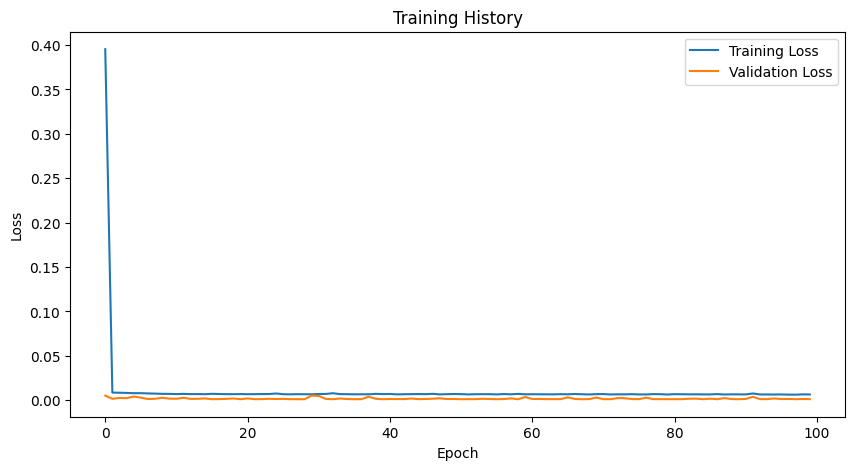

In [19]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()

## Make Predictions - FIXED inverse transform

In [20]:
# Get predictions on training set - FIXED
with torch.no_grad():
    train_predictions = model(X_train.to(device)).cpu().numpy()
    # Now we can directly inverse transform using scaler_y!
    train_predictions = scaler_y.inverse_transform(train_predictions).flatten()
    
    # Get actual training values
    y_train_actual = scaler_y.inverse_transform(y_train.numpy()).flatten()

In [21]:
# Get predictions on test set - FIXED
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()
    # Now we can directly inverse transform using scaler_y!
    test_predictions = scaler_y.inverse_transform(test_predictions).flatten()
    
    # Get actual test values
    y_test_actual = scaler_y.inverse_transform(y_test.numpy()).flatten()

In [22]:
# Calculate metrics
train_mse = np.mean((train_predictions - y_train_actual)**2)
test_mse = np.mean((test_predictions - y_test_actual)**2)

train_mae = np.mean(np.abs(train_predictions - y_train_actual))
test_mae = np.mean(np.abs(test_predictions - y_test_actual))

print(f"Training MSE: {train_mse:.2f}")
print(f"Testing MSE: {test_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

Training MSE: 1125.15
Testing MSE: 242.20
Training MAE: 13.77
Testing MAE: 10.37


ValueError: x and y must have same first dimension, but have shapes (1024,) and (1031,)

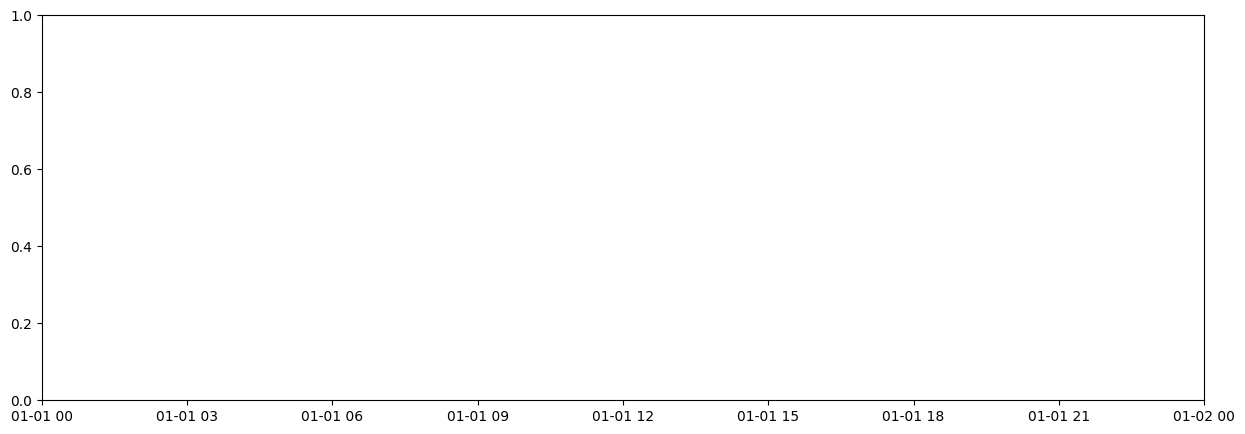

In [23]:
# Plot train predictions
train_dates = shifted_df.index[lookback:split_index]

plt.figure(figsize=(15, 5))
plt.plot(train_dates, y_train_actual, label='Actual', alpha=0.7)
plt.plot(train_dates, train_predictions, label='Predicted', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Training Set: Actual vs Predicted AQI')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Plot test predictions
test_dates = shifted_df.index[split_index:]

plt.figure(figsize=(15, 5))
plt.plot(test_dates, y_test_actual, label='Actual', alpha=0.7)
plt.plot(test_dates, test_predictions, label='Predicted', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Test Set: Actual vs Predicted AQI')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Future Predictions - FIXED!

In [ ]:
def predict_future(model, last_sequence, n_future, scaler_x, scaler_y, device):
    """
    Predict future AQI values - FIXED VERSION
    
    Args:
        model: trained LSTM model
        last_sequence: last 'lookback' days of SCALED data (in scaler_x space)
        n_future: number of days to predict
        scaler_x: fitted MinMaxScaler for features
        scaler_y: fitted MinMaxScaler for target
        device: torch device
    """
    model.eval()
    predictions = []
    current_sequence = last_sequence.copy()
    
    with torch.no_grad():
        for _ in range(n_future):
            # Prepare input
            x = torch.tensor(current_sequence).float().reshape(1, lookback, 1).to(device)
            
            # Predict (this gives us a scaled value in scaler_y space)
            pred_scaled = model(x).cpu().numpy()[0, 0]
            predictions.append(pred_scaled)
            
            # Update sequence: remove oldest, add newest
            # Note: we keep predictions in scaled space for feeding back
            current_sequence = np.append(current_sequence[1:], pred_scaled)
    
    # Inverse transform all predictions at once using scaler_y
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler_y.inverse_transform(predictions).flatten()
    
    return predictions

# Get last sequence from test set (already scaled in scaler_x space)
last_sequence = X_test[-1].cpu().numpy().flatten()

# Predict next 30 days
future_predictions = predict_future(model, last_sequence, 30, scaler_x, scaler_y, device)

# Create future dates
last_date = shifted_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Plot
plt.figure(figsize=(15, 5))
plt.plot(shifted_df.index[-100:], shifted_df['AQI'].values[-100:], label='Historical', alpha=0.7)
plt.plot(future_dates, future_predictions, label='Future Predictions', color='red', marker='o')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI Future Predictions (Next 30 Days)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nFuture AQI Predictions:")
for date, pred in zip(future_dates[:10], future_predictions[:10]):
    print(f"{date.strftime('%Y-%m-%d')}: {pred:.2f}")